## Методы оптимизации

Оптимизация задачи нулевого порядка

Постановка задачи:

В проектируемой локальной сети есть заданное количество компьютеров.
Есть расстояния от каждого компьютера до сервера и до остальных компьютеров. Маршрутизаторы соединяются с сервером через оптоволокно стоимостью 12 р/м, а компьютеры - с маршрутизаторами соединяются через витую пару стоимостью 30 р/м.
Каждый маршрутизатор имеет 8 портов для витой пары и один оптический порт.
Сервер имеет неограниченное число оптических портов и портов для витой пары. Компьютер может соединяться с сервером напрямую или через маршрутизатор.
1. Построить ЦФ для расчёта стоимости оборудования ЛВС в общем виде. Учесть стоимость маршрутизатора, обоснованность его установки.
2. Построить поверхность стоимости от сумм расстояний для конкретного примера. Количество компьютеров — больше двух, располагаются не на одной линии в одной четверти относительно сервера.*

Целевая функция в общем виде:

$$f = Min(c_u \cdot \sum_{i=1}^{L}{(l_{pr} + l_{rs})_i}, \quad 
c_u \cdot \sum_{i=1}^{L}({l_pr})_i + (N_r \cdot R_c) + c_o \cdot \sum_{i=1}^{L}({l_{rs}})_i)$$

где:

$c_u$ - стоимость витой пары (руб./м)

$c_o$ - стоимость оптоволокна (руб./м)

$N_r = \frac{N_{comps}}{N_{ports}}$ - количество роутеров, $N_{comps}$ - количество компьютеров, $N_{ports}$ - количество портов в одном роутере

$R_c$ - стоимость одного роутера (руб)

$l_{pr}$ - среднее расстояние от компьютера до маршрутизатора (м)

$l_{rs}$ - среднее расстояние от маршрутизатора до сервера (м)

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
plt.style.use('fivethirtyeight')

In [6]:
# Вариативный параметр: суммы расстояний, метров
agg_len = np.arange(100, 11000, 100).astype('int64')

# Принимаем, что маршрутизаторы стоят в офисах, а сервер расположен в пределах района,
# тогда условно можно задать соотношение расстояний: 
# 20% пути от компьютеров к маршрутизаторам, и ещё 80% - от маршрутизаторов до сервера

# Входные параметры системы

opt_cost = 12 # стоимость метра оптоволоконного кабеля, руб
utp_cost = 30 # стоимость метра utp кабеля, руб
switch_cost = 3000 # примем среднюю стоимость маршрутизатора 
n_utp_ports = 8 # количество utp портов маршрутизатора
n_opt_ports = 1 # количество оптоволоконных портов маршрутизатора
server_max_load = np.inf # количество портов сервера 
n_pcs = 100 # количество компьютеров в сети

pp1 = 0.8 # коэффициент соотношения макс. расстояний pc<->switch / switch<->server
pp2 = 1 - pp1
switch2server_len = agg_len * pp1 # расстояние от маршрутизатора до сервера 
pc2switch_len = agg_len * pp2 # расстояние от компьютера до маршрутизатора
pc2server_len = agg_len

# возвращает стоимость сети с максимальным использованием витой пары
def get_max_utp_cost(utp_cost, 
                     pc2server_len, 
                     n_pcs, 
                     n_utp_ports):
    
    # максимальное количество маршрутизаторов - для 8 компьютеров = 1
    n_max_switches = (n_pcs // n_utp_ports if n_pcs % n_utp_ports == 0 else n_pcs // n_utp_ports + 1)
    # максимальная стоимость сети, если соединять каждый компьютер витой парой с сервером, руб
    max_utp2server_cost = utp_cost * pc2server_len * n_pcs
    # Функция стоимости сети с максимальным использованием витой пары, руб
    TF1 = max_utp2server_cost
    return TF1

# возвращает стоимость сети с максимальным использованием оптоволокна с учетом использования маршрутизаторов
def get_max_opt_cost(utp_cost,
                     opt_cost,
                     pc2switch_len,
                     switch2server_len,
                     n_pcs, 
                     switch_cost):
    
    # максимальное количество маршрутизаторов - для 8 компьютеров = 1
    n_max_switches = (n_pcs // n_utp_ports if n_pcs % n_utp_ports == 0 else n_pcs // n_utp_ports + 1) 
    # Стоимость витой пары для суммы расстояний от всех компьютеров ко всем маршрутизаторам
    max_utp2switch_cost = utp_cost * pc2switch_len * n_pcs
    # Максимальная стоимость маршрутизаторов
    max_switches_cost = n_max_switches * switch_cost
    # Стоимость оптоволоконного кабеля для суммы расстояний от всех маршрутизаторов до сервера
    max_opt2server_cost = n_max_switches * (opt_cost * switch2server_len)
    # Функция стоимости сети с максимальным использованием оптоволокна, руб
    TF2 = max_utp2switch_cost + max_opt2server_cost + max_switches_cost
    return TF2

# Минимизация аргументов целевой фукнции
def get_tf(*args):
    TF = np.minimum(*args)
    return TF


In [7]:
TF1 = get_max_utp_cost(utp_cost, pc2server_len, n_pcs, n_utp_ports)
TF2 = get_max_opt_cost(utp_cost, opt_cost, pc2switch_len, switch2server_len, n_pcs, switch_cost)
TF = get_tf(TF1, TF2)

# вспомогательные функции
tf_min1 = get_max_utp_cost(utp_cost, pc2server_len, int(n_pcs/2), n_utp_ports)
tf_min2 = get_max_opt_cost(utp_cost, opt_cost, pc2switch_len, switch2server_len, int(n_pcs/2), switch_cost)
tf_min = get_tf(tf_min1, tf_min2)

tf_max1 = get_max_utp_cost(utp_cost, pc2server_len, n_pcs*2, n_utp_ports)
tf_max2 = get_max_opt_cost(utp_cost, opt_cost, pc2switch_len, switch2server_len, n_pcs*2, switch_cost)
tf_max = get_tf(tf_max1, tf_max2)

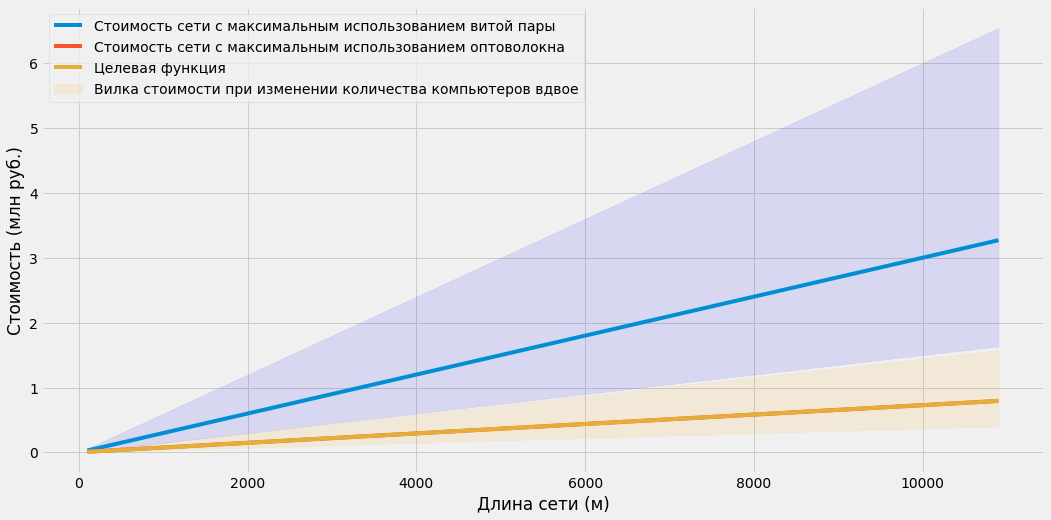

In [11]:
fig, ax = plt.subplots(figsize=(16,8))
ax.plot(agg_len, TF1/10e6)                                                                                
ax.plot(agg_len, TF2/10e6)                                                                                
ax.plot(agg_len, TF/10e6)
ax.fill_between(agg_len,
                tf_min/10e6,
                tf_max/10e6,
                color='orange',
                alpha=.1)
ax.fill_between(agg_len,
                tf_min1/10e6,
                tf_max1/10e6,
                color='b',
                alpha=.1)

ax.set_xlabel('Длина сети (м)')
ax.set_ylabel('Стоимость (млн руб.)')
                                                                                       
 
lgnd = ax.legend(['Стоимость сети с максимальным использованием витой пары',
                  'Стоимость сети с максимальным использованием оптоволокна',
                  'Целевая функция',
                  'Вилка стоимости при изменении количества компьютеров вдвое'], loc='upper left')                                                       
 
plt.show()  